# Install Packages

In this approach data is segmented and feature are calculated for each segment. Then these features are averaged.

Butterworth is applied before segmentation
Classifier are tuned before feature selection.
Butterworth ranges from .1 to 30 HZ

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [61]:
!pip install wfdb
!pip install mne
!pip install nitime

In [62]:
!pip install git+https://github.com/forrestbao/pyeeg.git
!pip install git+https://github.com/raphaelvallat/entropy.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-1nhb0xkf
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-1nhb0xkf
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28121 sha256=83772ecb2ac5d36d3bb3a3edd95054c503222b7bac631c9684e8a239c2b12282
  Stored in directory: /tmp/pip-ephem-wheel-cache-gi76tu2v/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg
  Cloning https://github.com/raphaelvallat/entropy.git to /tmp/pip-req-build-01cql0wn
  Running command git clone -q https://github.com/raphaelvallat/entropy.git /tmp/pip-req-build-01cql0wn
  Created wheel for entropy: filename=entropy-0.1.0-cp36-none-any.whl size=14098 sha256=b0a2efe2644c95b7493f852747dddefc8d34d988cfd2818d54add7e09b405505
  Stored in directory: /tmp/pip-ephem-wheel-cache-8sl5_z09/wheels/60/ed/d3/b715e38438f1f39edb1383aea79c578073953b25fa576fc71e
Successfully built entropy


# Download data

In [63]:
import wfdb
dbs = wfdb.get_dbs()
wfdb.dl_database('eegmat','data')

Finished downloading files


# Read data

In [0]:
import glob
import os
import mne
import re
import numpy as np


In [0]:
from scipy import signal

nyq = 0.5 * 500
l=0.1
low = l / nyq
high = 30 / nyq
b, a = signal.butter(4, [low,high], 'band')

In [66]:

path = r'data/' # use your path
all_files = glob.glob(os.path.join(path, "*.edf")) 

i=0
j=0
subject_1=[]
subject_2=[]

for filename in (all_files):
    if int(re.findall(r'\d+',filename)[1])==1:
        data=mne.io.read_raw_edf(filename,preload=True).get_data()[0:-3,10000:40000]
        data=signal.filtfilt(b, a, data)  
        subject_1.append(data.T)
    else:
        data=mne.io.read_raw_edf(filename,preload=True).get_data()[0:-3,0:30000]
        data=signal.filtfilt(b, a, data)  
        subject_2.append(data.T)        

Extracting EDF parameters from /content/data/Subject07_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /content/data/Subject23_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/data/Subject06_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/data/Subject31_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 39999  =      0.000 ...    79.998 secs...
Extracting EDF parameters from /content/data/Subject20_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   1

# Feature Extraction

In [0]:
from scipy import stats
import pyeeg
from entropy import *
import pywt
from nitime import algorithms as alg
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

np.warnings.filterwarnings('ignore')

In [0]:
def mean(data):
    return np.mean(data,axis=0)
    
def std(data):
    return np.std(data,axis=0)

def ptp(data):
    return np.ptp(data,axis=0)

def var(data):
        return np.var(data,axis=0)

def minim(data):
      return np.min(data,axis=0)


def maxim(data):
      return np.max(data,axis=0)


def mean_square(data):
      return np.mean(data**2,axis=0)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)


def skewness(data):
    return stats.skew(data,axis=0)

def kurtosis(data):
    return stats.kurtosis(data,axis=0)

def zero_crossing(data):
    return np.argmax(np.diff(np.sign(data),axis=0),axis=0)

def app_epy(data):
    result=[]
    for i in data.T:
        result.append(app_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)

def perm_epy(data):
    result=[]
    for i in data.T:
        result.append(perm_entropy(i, order=3, normalize=True))
    return np.array(result)

def svd_epy(data):
    result=[]
    for i in data.T:
        result.append(svd_entropy(i, order=3, delay=1, normalize=True))
    return np.array(result)

def spectral_epy(data):
    result=[]
    for i in data.T:
        result.append(spectral_entropy(i, 100, method='welch', normalize=True))
    return np.array(result)

def sample_epy(data):
    result=[]
    for i in data.T:
        result.append(sample_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)


def katz(data):
    result=[]
    for i in data.T:
        result.append(katz_fd(i))
    return np.array(result)

def higuchi(data):
    result=[]
    for i in data.T:
        result.append(higuchi_fd(i))
    return np.array(result)


def petrosian(data):
    result=[]
    for i in data.T:
        result.append(petrosian_fd(i))
    return np.array(result)

def autogressiveModelParameters(data):
    feature = []
    for i in data.T:
        coeff, sig = alg.AR_est_YW(i, order=5)
        feature.append(np.mean(coeff))
    return np.array(feature)

def teager(x):
    for i in range(len(x)-1):
        return x[i]**2 - (x[i-1]*x[i+1])


        
def hjorth_mobility(data):
    return np.divide(np.std(np.diff(data,axis=0),axis=0),np.std(data,axis=0))

def hjorth_complexity(data):
    return np.divide(hjorth_mobility(np.diff(data,axis=0)),  hjorth_mobility(data))      





In [0]:

def concatenate(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data),zero_crossing(data),
                          app_epy(data),perm_epy(data),svd_epy(data),spectral_epy(data),sample_epy(data),
                          katz(data),higuchi(data),petrosian(data),
                          hjorth_mobility(data),hjorth_complexity(data)),axis=0)

In [0]:
features1=[]
for f in subject_1:
    feature=[]
    b=f.reshape(-1,3000,18)
    for i in b:
        feature.append(concatenate(i))
    features1.append(np.mean(np.array(feature),axis=0))

In [0]:
features2=[]
for f in subject_2:
    feature=[]
    b=f.reshape(-1,3000,18)
    for i in b:
        feature.append(concatenate(i))
    features2.append(np.mean(np.array(feature),axis=0))

In [72]:
len(features1),len(features2)

(36, 36)

In [0]:
x1=np.array(features1)        
x2=np.array(features2)      

X=np.concatenate((x1,x2),axis=0)

y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))

In [74]:
X.shape,y.shape

((72, 396), (72,))

In [0]:
np.save('data_0.1-30Hz',X)
np.save('labels_0.1-30Hz',y)

# Feature Selection

In [0]:
feature_list=['mean','std','ptp','var','minim','maxim','mean_square','rms','abs_diffs_signal','skewness','kurtosis','zero_crossing',
'app_epy','perm_epy','svd_epy','spectral_epy','sample_epy','katz','higuchi','petrosian','hjorth_mobility','hjorth_complexity']

In [20]:
feature_selected=[]
for i in range(100):
  clf=LogisticRegression()
  randomize = np.arange(len(X))
  np.random.shuffle(randomize)
  X = X[randomize]
  y = y[randomize]
  for i,j in zip(range(0,396,18),feature_list):
    X_new=X[:,i:i+18]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y,test_size=0.3, random_state=42,stratify=y)
    sc=StandardScaler()
    X_train=sc.fit_transform(X_train)
    X_test=sc.transform(X_test)
    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)  
    acc=metrics.accuracy_score(y_test, y_pred)
    #print("Accuracy of ",j,metrics.accuracy_score(y_test, y_pred))
    if acc>0.70:
      feature_selected.append(j)
 # print('-------------------------------------------------------------------')


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [21]:
count= {x:feature_selected.count(x) for x in feature_selected}
from collections import Counter
c = Counter(count)
print(c.most_common())

[('maxim', 56), ('ptp', 50), ('minim', 34), ('mean_square', 32), ('var', 29), ('rms', 28), ('std', 27), ('abs_diffs_signal', 17), ('spectral_epy', 15), ('skewness', 8), ('kurtosis', 7), ('higuchi', 7), ('katz', 4), ('svd_epy', 3), ('sample_epy', 3), ('app_epy', 2), ('perm_epy', 2), ('petrosian', 2), ('mean', 2), ('hjorth_complexity', 1), ('hjorth_mobility', 1)]


# Classification

In [0]:
#%% split data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42,stratify=y)

In [0]:
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [78]:
from sklearn.svm import SVC
clf=SVC(kernel='rbf')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_pred))
print('accuracy is ',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82         8
         1.0       0.83      0.71      0.77         7

    accuracy                           0.80        15
   macro avg       0.81      0.79      0.80        15
weighted avg       0.80      0.80      0.80        15

accuracy is  0.8


# Fine Tuning

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

clf = SVC(kernel="rbf")
Cs = [ 1,2,3,5,7,10,15,30,50,70,100]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7535714285714287


{'classifier__C': 2, 'classifier__gamma': 0.001}

### KNN

In [80]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

n_neighbors  = [ 3,4,5,6,7,8,9]
weights  = ['uniform','distance']
metric=['minkowski','manhattan','euclidean']
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__n_neighbors=n_neighbors,classifier__weights=weights,classifier__metric=metric),cv=5,n_jobs=-1,iid=False) 
results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_


0.7017857142857143


{'classifier__metric': 'minkowski',
 'classifier__n_neighbors': 7,
 'classifier__weights': 'uniform'}

### nu

In [81]:
from sklearn.svm import SVC, LinearSVC, NuSVC

clf = NuSVC(kernel="rbf")
nu = [0.1,0.3,0.5,0.7,1]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__nu=nu,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7267857142857143


{'classifier__gamma': 0.001, 'classifier__nu': 0.7}

### lR

In [82]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
C = [ 1,2,3,5,7,10,15,30,50,70,100]
penalty=["l1","l2"]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__C=C,classifier__penalty=penalty),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.8339285714285714


{'classifier__C': 70, 'classifier__penalty': 'l1'}

# Cross Validation

In [0]:

from sklearn.preprocessing import StandardScaler,MaxAbsScaler

scalar=StandardScaler()

In [0]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [0]:
classifiers = [
    KNeighborsClassifier(n_neighbors=8,weights='distance',metric='manhattan'),
    SVC(kernel="rbf",C=1,gamma=0.001),
    NuSVC(nu=0.7,gamma=0.001),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(C=1,penalty='l1')]


In [0]:
pipeline = Pipeline([('transformer', scalar),('estimator', clf)])

In [87]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy=[]
accuracy_std=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy.append(np.array(scores).mean())
    accuracy_std.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())

KNeighborsClassifier
****Results****
Accuracy: 65.5357%
SVC
****Results****
Accuracy: 72.6786%
NuSVC
****Results****
Accuracy: 72.6786%
DecisionTreeClassifier
****Results****
Accuracy: 54.2857%
RandomForestClassifier
****Results****
Accuracy: 61.2500%
AdaBoostClassifier
****Results****
Accuracy: 62.3214%
GradientBoostingClassifier
****Results****
Accuracy: 55.5357%
GaussianNB
****Results****
Accuracy: 68.5714%
LinearDiscriminantAnalysis
****Results****
Accuracy: 67.8571%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 49.1071%
LogisticRegression
****Results****
Accuracy: 71.4286%


Text(0.5, 1.0, 'Classifiers')

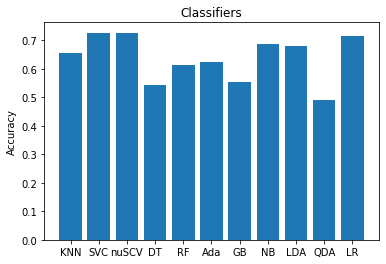

In [88]:
import matplotlib.pyplot as plt
classifier=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR']
y_pos = np.arange(len(classifier))
plt.bar(y_pos,np.array(accuracy))
plt.xticks(y_pos, classifier)
plt.ylabel('Accuracy')
plt.title('Classifiers')

# Principle Component Analysis

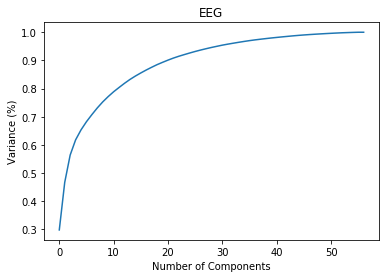

In [89]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('EEG')
plt.show()

In [0]:

clf = SVC(kernel='rbf')
pca = PCA(n_components=20)

pipeline = Pipeline([('transformer', scalar),('selector',pca), ('estimator', clf)])


In [91]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_pca=[]
std_pca=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_pca.append(np.array(scores).mean())
    std_pca.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 63.0357%
SVC
****Results****
Accuracy: 72.6786%
NuSVC
****Results****
Accuracy: 72.6786%
DecisionTreeClassifier
****Results****
Accuracy: 71.2500%
RandomForestClassifier
****Results****
Accuracy: 68.2143%
AdaBoostClassifier
****Results****
Accuracy: 68.5714%
GradientBoostingClassifier
****Results****
Accuracy: 68.3929%
GaussianNB
****Results****
Accuracy: 72.6786%
LinearDiscriminantAnalysis
****Results****
Accuracy: 79.1071%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 60.0000%
LogisticRegression
****Results****
Accuracy: 76.4286%


In [92]:
from sklearn.model_selection import GridSearchCV

clf = SVC(kernel="rbf")
n_components = [5,10,15,20]
Cs = [0.001,0.1, 1,2,3,5,7,10,15,30]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scalar',sc),('selector', pca), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(selector__n_components=n_components,
                              classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

0.7821428571428571


{'classifier__C': 3, 'classifier__gamma': 0.001, 'selector__n_components': 15}

# RFE

In [0]:
from sklearn.preprocessing import MaxAbsScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE


In [0]:
# from sklearn.model_selection import GridSearchCV

# clf = SVC(kernel="rbf")
# n_features = [20,30,40,50,70,100]
# step=[5,7,9,10]
# Cs = [0.001,0.1, 1,2,3,5,7,10,15,30]
# gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
# pipe = Pipeline(steps=[('rfe', rfe), ('classifier', clf)])
# estimator = GridSearchCV(pipe,
#                          dict(rfe__step=step,rfe__n_features_to_select=n_features,
#                               classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

# results = estimator.fit(X,y)
# results.best_params_

In [0]:

clf = SVC(kernel='rbf')
rfe=RFE(SVC(kernel='linear'),n_features_to_select=20,step=5,verbose=0)   

pipeline = Pipeline([('transformer', scalar),('selector',rfe), ('estimator', clf)])


In [96]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_rfe=[]
std_rfe=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_rfe.append(np.array(scores).mean())
    std_rfe.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 70.8929%
SVC
****Results****
Accuracy: 69.4643%
NuSVC
****Results****
Accuracy: 68.5714%
DecisionTreeClassifier
****Results****
Accuracy: 62.5000%
RandomForestClassifier
****Results****
Accuracy: 64.1071%
AdaBoostClassifier
****Results****
Accuracy: 62.5000%
GradientBoostingClassifier
****Results****
Accuracy: 62.6786%
GaussianNB
****Results****
Accuracy: 59.6429%
LinearDiscriminantAnalysis
****Results****
Accuracy: 68.3929%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 61.6071%
LogisticRegression
****Results****
Accuracy: 70.8929%


# SKbest

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [0]:

clf = SVC(kernel='rbf')
skbest=SelectKBest(f_classif, k=5)
pipeline = Pipeline([('transformer', scalar),('selector',rfe), ('estimator', clf)])


In [99]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_kbest=[]
std_kbest=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_kbest.append(np.array(scores).mean())
    std_kbest.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 70.8929%
SVC
****Results****
Accuracy: 69.4643%
NuSVC
****Results****
Accuracy: 68.5714%
DecisionTreeClassifier
****Results****
Accuracy: 54.2857%
RandomForestClassifier
****Results****
Accuracy: 64.2857%
AdaBoostClassifier
****Results****
Accuracy: 62.5000%
GradientBoostingClassifier
****Results****
Accuracy: 62.6786%
GaussianNB
****Results****
Accuracy: 59.6429%
LinearDiscriminantAnalysis
****Results****
Accuracy: 68.3929%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 61.6071%
LogisticRegression
****Results****
Accuracy: 70.8929%


# VarianceThreshold

In [0]:
from sklearn.feature_selection import VarianceThreshold
clf = SVC(kernel='rbf')
selector = VarianceThreshold(0.1)
pipeline = Pipeline([('transformer', scalar),('selector',selector), ('estimator', clf)])


In [101]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_var=[]
std_var=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_var.append(np.array(scores).mean())
    std_var.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 65.5357%
SVC
****Results****
Accuracy: 72.6786%
NuSVC
****Results****
Accuracy: 72.6786%
DecisionTreeClassifier
****Results****
Accuracy: 56.9643%
RandomForestClassifier
****Results****
Accuracy: 68.5714%
AdaBoostClassifier
****Results****
Accuracy: 62.3214%
GradientBoostingClassifier
****Results****
Accuracy: 58.3929%
GaussianNB
****Results****
Accuracy: 68.5714%
LinearDiscriminantAnalysis
****Results****
Accuracy: 67.8571%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 49.1071%
LogisticRegression
****Results****
Accuracy: 71.4286%


# result

In [102]:
len(accuracy),len(accuracy_pca),len(accuracy_rfe),len(accuracy_kbest),len(accuracy_var)

(11, 11, 11, 11, 11)

In [0]:
result=pd.DataFrame([accuracy,accuracy_pca,accuracy_rfe,accuracy_kbest,accuracy_var],
                    index=['Accuracy','PCA',"RFE",'kbest','VAR'],
                    columns=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR'])

In [0]:
result=result.T

In [105]:
def _color_red_or_green(val):
    color = 'red' if val < 0.7 else 'green'
    return 'color: %s' % color
result.style.applymap(_color_red_or_green)    

,Accuracy,PCA,RFE,kbest,VAR
KNN,0.655357,0.630357,0.708929,0.708929,0.655357
SVC,0.726786,0.726786,0.694643,0.694643,0.726786
nuSCV,0.726786,0.726786,0.685714,0.685714,0.726786
DT,0.542857,0.7125,0.625,0.542857,0.569643
RF,0.6125,0.682143,0.641071,0.642857,0.685714
Ada,0.623214,0.685714,0.625,0.625,0.623214
GB,0.555357,0.683929,0.626786,0.626786,0.583929
NB,0.685714,0.726786,0.596429,0.596429,0.685714
LDA,0.678571,0.791071,0.683929,0.683929,0.678571
QDA,0.491071,0.6,0.616071,0.616071,0.491071


In [0]:
#highest accuracy is 76% check PCA section